<a href="https://colab.research.google.com/github/Michel93DM/Intent_Classification_NLP2023/blob/main/Fine_Tuning_a_BERT_Model_Intent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 419.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 23.0 MB/s eta 0:00:00


In [ ]:
import gzip
import shutil
import time

import pandas as pd
import requests
import torch
import torch.nn.functional as F
import torchtext

import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

## General settings

In [ ]:
torch.backends.cudnn.deterministic = True
Random_seed= 123
torch.manual_seed(Random_seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 3

## Loading & Processing Data

In [ ]:
from datasets import load_dataset

maptask = load_dataset("miam", "maptask")

Generating train split:   0%|          | 0/25382 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5335 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/maptask/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
maptask

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 25382
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 5221
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 5335
    })
})

In [ ]:
maptask_train_U = maptask['train']['Utterance']

In [ ]:
maptask_train_L = maptask['train']['Label']

In [ ]:
df_train_U = pd.DataFrame (maptask_train_U, columns = ['Utterance'])
df_train_L = pd.DataFrame (maptask_train_L, columns = ['Label'])

In [ ]:
df_train = pd.merge(df_train_U, df_train_L, left_index=True, right_index=True)
df_train

,Utterance,Label
0,okay the start part is at the top left-hand co...,5
1,uh-huh,0
2,okay,1
3,uh-huh,11
4,ehm you're coming the s-- for three inches dow...,5
...,...,...
25377,well move from where you are now down to below...,5
25378,yeah,0
25379,and then up 'til and the finish is just here o...,5
25380,okay,0


In [ ]:
maptask_validation_U = maptask['validation']['Utterance']
maptask_validation_L = maptask['validation']['Label']

df_validation_U = pd.DataFrame (maptask_validation_U, columns = ['Utterance'])
df_validation_L = pd.DataFrame (maptask_validation_L, columns = ['Label'])

df_validation = pd.merge(df_validation_U, df_validation_L, left_index=True, right_index=True)
df_validation

,Utterance,Label
0,okay the start part is at the top left-hand co...,5
1,uh-huh,0
2,okay,1
3,uh-huh,11
4,ehm you're coming the s-- for three inches dow...,5
...,...,...
5216,on the left,0
5217,so it's the top corner,2
5218,just so if you just stop you know anywhere,3
5219,right,0


In [ ]:
maptask_test_U = maptask['test']['Utterance']
maptask_test_L = maptask['test']['Label']

df_test_U = pd.DataFrame (maptask_test_U, columns = ['Utterance'])
df_test_L = pd.DataFrame (maptask_test_L, columns = ['Label'])

df_test = pd.merge(df_test_U, df_test_L, left_index=True, right_index=True)
df_test

,Utterance,Label
0,start at the extinct volcano,5
1,go down around the tribal settlement and then,5
2,whereabouts is the tribal settlement,6
3,it's at the bottom it's to the left of the e--...,10
4,right,0
...,...,...
5330,and i'm going straight down two inches,2
5331,yeah,11
5332,and then to the right two inches and that's th...,5
5333,right,0


## Splitting the Datasets

the dataset is splitted into 70% training, 10% validation and the rest into testing(20%)

In [ ]:
train_texts = df_train['Utterance'].values
train_labels = df_train['Label'].values

valid_texts = df_validation['Utterance'].values
valid_labels = df_validation['Label'].values

test_texts = df_test['Utterance'].values
test_labels = df_test['Label'].values


## Tokenizing the Datasets

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', num_labels=31)

train_encodings = tokenizer(list(train_texts), truncation = True, padding = True)
valid_encodings = tokenizer(list(valid_texts), truncation = True, padding = True)
test_encodings = tokenizer(list(test_texts), truncation = True, padding = True)

In [ ]:
class MIAMDataset(torch.utils.data.Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item={key: torch.tensor(val[idx])
             for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)
    
train_dataset = MIAMDataset(train_encodings, train_labels)
valid_dataset = MIAMDataset(valid_encodings, valid_labels)
test_dataset  = MIAMDataset(test_encodings, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16, shuffle = True )
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=16, shuffle = False )
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=16, shuffle = False )

## Loading and fine_tuning a Pre-trained Bert

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=31)
model.to(device)
model.train()

optim = torch.optim.Adam(model.parameters(), lr = 5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

### Accuracy function

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 2.4 MB/s eta 0:00:00


In [ ]:
import evaluate
import numpy as np

import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)
    f1_micro_score = f1.compute(predictions=predictions, references=labels, average='micro')
    f1_macro_score = f1.compute(predictions=predictions, references=labels, average='macro')
    recall_micro_score = recall.compute(predictions=predictions, references=labels, average='micro')
    return {'Accuracy': accuracy_score,
            'F1_micro': f1_micro_score,
            'F1_macro': f1_macro_score,
            'Recall': recall_micro_score}

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
training_args = TrainingArguments('test_trainer',
                           evaluation_strategy = 'epoch',
                           num_train_epochs=3, #change to 2 or 3 later
                           per_device_train_batch_size = 16,
                           per_device_eval_batch_size = 16,
                           logging_dir = './logs',
                           logging_steps = 1000,
)

trainer_maptask2 = Trainer(
                           model=model,
                           args=training_args,
                           train_dataset=train_dataset,
                           eval_dataset=valid_dataset,
                           optimizers = (optim, None),
                           compute_metrics=compute_metrics,
                           )

start_time = time.time()
trainer_maptask2.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,1.266400,0.971414,{'accuracy': 0.6535146523654473},{'f1': 0.6535146523654473},{'f1': 0.5867946944742424},{'recall': 0.6535146523654473}
2,0.949100,0.864445,{'accuracy': 0.6864585328481134},{'f1': 0.6864585328481134},{'f1': 0.6465827173108867},{'recall': 0.6864585328481134}
3,0.845100,0.788044,{'accuracy': 0.7119325799655238},{'f1': 0.7119325799655238},{'f1': 0.6948848089430304},{'recall': 0.7119325799655238}


Trainer is attempting to log a value of "{'accuracy': 0.6535146523654473}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6535146523654473}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.5867946944742424}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.6535146523654473}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.6864585328481134}" of type <class 'd

TrainOutput(global_step=4761, training_loss=0.9879781510293596, metrics={'train_runtime': 939.8002, 'train_samples_per_second': 81.024, 'train_steps_per_second': 5.066, 'total_flos': 2404753246731528.0, 'train_loss': 0.9879781510293596, 'epoch': 3.0})

In [ ]:
print(trainer_maptask2.evaluate())

Trainer is attempting to log a value of "{'accuracy': 0.7119325799655238}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7119325799655238}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6948848089430304}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7119325799655238}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.7880440354347229, 'eval_Accuracy': {'accuracy': 0.7119325799655238}, 'eval_F1_micro': {'f1': 0.7119325799655238}, 'eval_F1_macro': {'f1': 0.6948848089430304}, 'eval_Recall': {'recall': 0.7119325799655238}, 'eval_runtime': 13.7329, 'eval_samples_per_second': 380.181, 'eval_steps_per_second': 23.811, 'epoch': 3.0}


In [ ]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    
    for batch_idx, batch in enumerate(train_loader):
        ## Prepare data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        ## Forward pass
        outputs = model(input_ids, attention_mask = attention_mask , labels = labels)
        
        loss, logits = outputs['loss'], outputs['logits']
        
        ## Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        ## logging
        if not batch_idx % 250:
            print(f'Epoch:{epoch+1:04d}/{NUM_EPOCHS:04d}'
                 f' | Batch'
                 f' {batch_idx:04d}/'
                 f' {len(train_loader):04d}|'
                 f' Loss: {loss:.4f}')
    
    model.eval()
    
    with torch.set_grad_enabled(False):
        print(f'Training accuracy:'
             f'{compute_accuracy(model, train_loader, device):.2f}%'
             f'\nValid accuracy:' 
             f'{compute_accuracy(model, valid_loader,device):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    

print(f'Total Training Time : {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader , device):.2f}%')
        


In [ ]:
train_texts.tolist()

AttributeError: ignored

In [ ]:
y_pred = model(train_texts.tolist())

AttributeError: ignored

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
names = pd.unique(train_labels)
print(classification_report(np.array(train_labels).flatten(), np.array(train_labels).flatten(), target_names=names))

TypeError: ignored

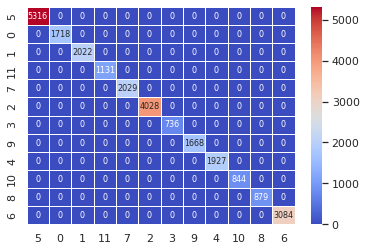

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn
names = pd.unique(train_labels)
cm = confusion_matrix(np.array(train_labels).flatten(), np.array(train_labels).flatten())
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap='RdBu', linewidth=0.5, fmt="")
plt.show()

In [ ]:
len(pd.unique(train_labels))

12